In [77]:
# Cell 1: 导入依赖
import os
import time
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import math
from torchinfo import summary
from scipy.special import erfc
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置支持中文的字体
rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 选择一个支持中文的字体
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

#from configs import get_cfg
#from dataset import get_dataloader
#from model import VQVAE
#from pixelcnn_model import PixelCNNWithEmbedding

USE_LMDB = False


In [78]:
#预处理

# 选择设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1.读取 数据集文件

clean_data = np.load(r'dataset_isi_normalized\qpsk_clean.npy')

train_data = clean_data[0:100000]
# 打印数据的形状以确认
print(f"原始数据形状：{clean_data.shape}")

# 加噪
def add_awgn_noise_np(clean_data, EbN0_db):
    noisy_data = np.zeros(clean_data.shape)
    # 计算信号功率
    signal_power = np.mean((np.abs(clean_data[:,0,:]) ** 2) + (np.abs(clean_data[:,1,:]) ** 2))
    EbN0_linear = 10**(EbN0_db/10)
    N0 = signal_power / EbN0_linear
    noise_std = np.sqrt(N0/2)
    # 生成I/Q两路独立高斯噪声
    noise_I = noise_std * np.random.randn(*clean_data[:,0,:].shape)
    noise_Q = noise_std * np.random.randn(*clean_data[:,1,:].shape)
    
    # 加噪（模拟实际信道）
    noisy_data[:,0,:] = clean_data[:,0,:] + noise_I;  # I路接收信号
    noisy_data[:,1,:] = clean_data[:,1,:] + noise_Q;  # Q路接收信号

    return noisy_data

def add_awgn_noise_torch(clean_data, EbN0_db):
    """
    clean_data: [batch, 2, length]  torch.Tensor (float, 可在 GPU 上)
    EbN0_db: 信噪比
    返回加噪后的信号，类型和设备与输入相同
    """
    # 计算信号功率 (I/Q 平均)
    signal_power = (clean_data[:,0,:].pow(2) + clean_data[:,1,:].pow(2)).mean()

    # 计算噪声功率
    EbN0_linear = 10 ** (EbN0_db / 10)
    N0 = signal_power / EbN0_linear
    noise_std = torch.sqrt(N0/2)

    # 生成 I/Q 两路独立高斯噪声
    noise_I = noise_std * torch.randn_like(clean_data[:,0,:])
    noise_Q = noise_std * torch.randn_like(clean_data[:,1,:])

    # 加噪
    noisy_data = clean_data.clone()
    noisy_data[:,0,:] += noise_I
    noisy_data[:,1,:] += noise_Q

    return noisy_data



原始数据形状：(120000, 2, 48)


In [79]:
class Dataset(Dataset):
    def __init__(self, start_samples, end_samples, seq_len=48, n_channels=2, n_classes=4):
        self.x = np.load(r'dataset_isi_normalized\qpsk_clean.npy')
        self.y = np.load(r'dataset_isi_normalized\qpsk_impaired.npy')
        self.x = self.x[start_samples:end_samples]
        self.y = self.y[start_samples:end_samples]


    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [80]:
def get_signal_shape():
    return (2, 48)  # 2个通道，长度为48的信号

class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_len: int, d_model: int):
        super().__init__()
        assert d_model % 2 == 0
        pe = torch.zeros(max_seq_len, d_model)
        i_seq = torch.linspace(0, max_seq_len - 1, max_seq_len)
        j_seq = torch.linspace(0, d_model - 2, d_model // 2)
        pos, two_i = torch.meshgrid(i_seq, j_seq)
        pe_2i = torch.sin(pos / 10000**(two_i / d_model))
        pe_2i_1 = torch.cos(pos / 10000**(two_i / d_model))
        pe = torch.stack((pe_2i, pe_2i_1), 2).reshape(max_seq_len, d_model)
        self.embedding = nn.Embedding(max_seq_len, d_model)
        self.embedding.weight.data = pe
        self.embedding.requires_grad_(False)

    def forward(self, t):
        return self.embedding(t)

class UnetBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, residual=False, cond_c=0):
        super().__init__()
        # 增加 cond_c 参数，用于处理条件信号的通道数
        self.ln = nn.LayerNorm(shape)
        # 调整第一个卷积层的输入通道，以容纳条件信号
        self.conv1 = nn.Conv1d(in_c + cond_c, out_c, 3, 1, 1)
        self.conv2 = nn.Conv1d(out_c, out_c, 3, 1, 1)
        self.activation = nn.ReLU()
        self.residual = residual
        if residual:
            if in_c + cond_c == out_c:
                self.residual_conv = nn.Identity()
            else:
                self.residual_conv = nn.Conv1d(in_c + cond_c, out_c, 1)

    def forward(self, x, c_in=None):
        # 如果存在条件信号，将其与主信号拼接
        if c_in is not None:
            x = torch.cat([x, c_in], dim=1)
        out = self.ln(x)
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        if self.residual:
            out += self.residual_conv(x)
        out = self.activation(out)
        return out

class UNet(nn.Module):
    def __init__(self, n_steps, channels=[10, 20, 40, 80], pe_dim=10, residual=False):
        super().__init__()
        C, H = get_signal_shape()
        
        self.time_pe = PositionalEncoding(n_steps, pe_dim)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.pe_linears_en = nn.ModuleList()
        self.pe_linears_de = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        
        # ⚠️ Corrected: The input channel for cond_conv_en should be the raw signal's C.
        self.cond_conv_en = nn.Conv1d(C, channels[0], kernel_size=1)
        # ⚠️ Corrected: This layer's input channels must match the output of the mid block.
        self.cond_conv_mid = nn.Conv1d(channels[-1], channels[-1], kernel_size=1)
        
        prev_channel = C
        Hs = [H]
        cH = H
        for _ in range(len(channels) - 1):
            cH //= 2
            Hs.append(cH)
        
        # Encoder Blocks
        for channel, cH in zip(channels[0:-1], Hs[0:-1]):
            self.pe_linears_en.append(
                nn.Sequential(nn.Linear(pe_dim, prev_channel), nn.ReLU(),
                              nn.Linear(prev_channel, prev_channel)))
            self.encoders.append(
                nn.Sequential(
                    UnetBlock((prev_channel, cH), prev_channel, channel, residual=residual),
                    UnetBlock((channel, cH), channel, channel, residual=residual)))
            self.downs.append(nn.Conv1d(channel, channel, 2, 2))
            prev_channel = channel

        # Mid Block
        self.pe_mid = nn.Linear(pe_dim, prev_channel)
        channel = channels[-1]
        self.mid = nn.Sequential(
            UnetBlock((prev_channel, Hs[-1]), prev_channel, channel, residual=residual),
            UnetBlock((channel, Hs[-1]), channel, channel, residual=residual),
        )

        prev_channel = channel
        # Decoder Blocks
        for channel, cH in zip(channels[-2::-1], Hs[-2::-1]):
            self.pe_linears_de.append(nn.Linear(pe_dim, prev_channel))
            self.ups.append(nn.ConvTranspose1d(prev_channel, channel, 2, 2))
            self.decoders.append(
                nn.Sequential(
                    UnetBlock((channel * 2, cH), channel * 2, channel, residual=residual),
                    UnetBlock((channel, cH), channel, channel, residual=residual)))
            prev_channel = channel
            
        self.cond_conv_de = nn.Conv1d(channels[-1], channels[-2], kernel_size=1)
        self.conv_out = nn.Conv1d(prev_channel, C, 3, 1, 1)

    def forward(self, x, t, c):
        n = t.shape[0]
        t_pe = self.time_pe(t)
        
        # Process conditional signal `c` once at the beginning
        c_en = self.cond_conv_en(c)
        
        encoder_outs = []
        for i, (pe_linear, encoder, down) in enumerate(zip(self.pe_linears_en, self.encoders, self.downs)):
            pe = pe_linear(t_pe).reshape(n, -1, 1)
            x = encoder(x + pe)
            encoder_outs.append(x)
            x = down(x)

        pe = self.pe_mid(t_pe).reshape(n, -1, 1)
        x = self.mid(x + pe)

        # ⚠️ Corrected: Pass the mid-block output to the conditional layer
        c_mid = self.cond_conv_mid(x)

        for i, (pe_linear, decoder, up, encoder_out) in enumerate(zip(self.pe_linears_de, self.decoders, self.ups, encoder_outs[::-1])):
            pe = pe_linear(t_pe).reshape(n, -1, 1)
            x = up(x)
            
            # Pad the upsampled signal to match the encoder output's length
            pad_x = encoder_out.shape[2] - x.shape[2]
            x = F.pad(x, (pad_x // 2, pad_x - pad_x // 2))

            # Concatenate the encoder output (skip connection) with the upsampled signal
            x = torch.cat((encoder_out, x), dim=1)
            x = decoder(x + pe)
        
        # ⚠️ Note: The original code does not use the `c_mid` and `c_en` features in the decoder.
        # To fully implement a conditional model, you need to add these features to the decoder blocks as well.
        # This is a major design choice that impacts the final performance.

        x = self.conv_out(x)
        return x

In [81]:
class ConditionalDDPM():
    def __init__(self,
                 device,
                 n_steps: int,
                 min_beta: float = 0.0001,
                 max_beta: float = 0.02):
        betas = torch.linspace(min_beta, max_beta, n_steps).to(device)
        alphas = 1 - betas
        alpha_bars = torch.empty_like(alphas)
        product = 1
        for i, alpha in enumerate(alphas):
            product *= alpha
            alpha_bars[i] = product
        self.betas = betas
        self.n_steps = n_steps
        self.alphas = alphas
        self.alpha_bars = alpha_bars

    def sample_forward(self, x, t, eps=None):
        """
        正向扩散过程: 通过将噪声加到输入信号 x 上，逐步生成模糊的信号。
        """
        alpha_bar = self.alpha_bars[t].reshape(-1, 1, 1)  # For one-dimensional signal
        if eps is None:
            eps = torch.randn_like(x)  # Random noise of same shape as x
        res = eps * torch.sqrt(1 - alpha_bar) + torch.sqrt(alpha_bar) * x
        return res

    def sample_backward(self, signal_shape, net, device, simple_var=True, condition=None):
        """
        反向去噪过程: 从纯噪声信号开始，通过网络逐步去噪恢复信号。
        这里新增了 'condition' 参数。
        """
        x = torch.randn(signal_shape).to(device)  # Starting with random noise
        net = net.to(device)
        for t in range(self.n_steps - 1, -1, -1):
            # 将条件 'condition' 传递给下一步
            x = self.sample_backward_step(x, t, net, simple_var, condition)
        return x

    def sample_backward_step(self, x_t, t, net, simple_var=True, condition=None):
        """
        反向去噪的每一步：根据当前时间步的噪声预测和相应的方差进行信号更新。
        这里新增了 'condition' 参数，并将其作为网络的第三个输入。
        """
        n = x_t.shape[0]
        t_tensor = torch.tensor([t] * n, dtype=torch.long).to(x_t.device).unsqueeze(1)
        
        # 将条件 'condition' 传递给神经网络
        eps = net(x_t, t_tensor, condition)

        if t == 0:
            noise = 0  # No noise at t=0
        else:
            if simple_var:
                var = self.betas[t]
            else:
                var = (1 - self.alpha_bars[t - 1]) / (1 - self.alpha_bars[t]) * self.betas[t]
            noise = torch.randn_like(x_t)
            noise *= torch.sqrt(var)

        mean = (x_t - (1 - self.alphas[t]) / torch.sqrt(1 - self.alpha_bars[t]) * eps) / torch.sqrt(self.alphas[t])
        x_t = mean + noise

        return x_t

In [82]:
epoch_num = 100



# 实例化最优模型（替换原来的UNet）
model = UNet(n_steps=100)

ddpm = ConditionalDDPM(device=device, n_steps=100)


# 将模型加载到设备
model = model.to(device)

# 定义优化器 - 需要调整学习率
optimizer = torch.optim.AdamW(  # 改用AdamW，更适合大模型
    model.parameters(), 
    lr=1e-4,                    # 学习率
    weight_decay=1e-5,          # 调整权重衰减
    betas=(0.9, 0.999)          # 默认的beta参数
)

# 添加学习率调度器
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=epoch_num,           # 周期数
    eta_min=1e-6               # 最小学习率
)

# 损失函数
mse_loss = nn.MSELoss()

# ==================== 重要改动结束 ====================

In [ ]:
#4. 准备数据
# ==========================
train_data = Dataset(0, 100000)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_set, val_set = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)


Epoch [1/100] Train Loss: 0.424693, Val Loss: 0.188764
✅ 验证损失下降，保存模型 (loss: 0.188764)


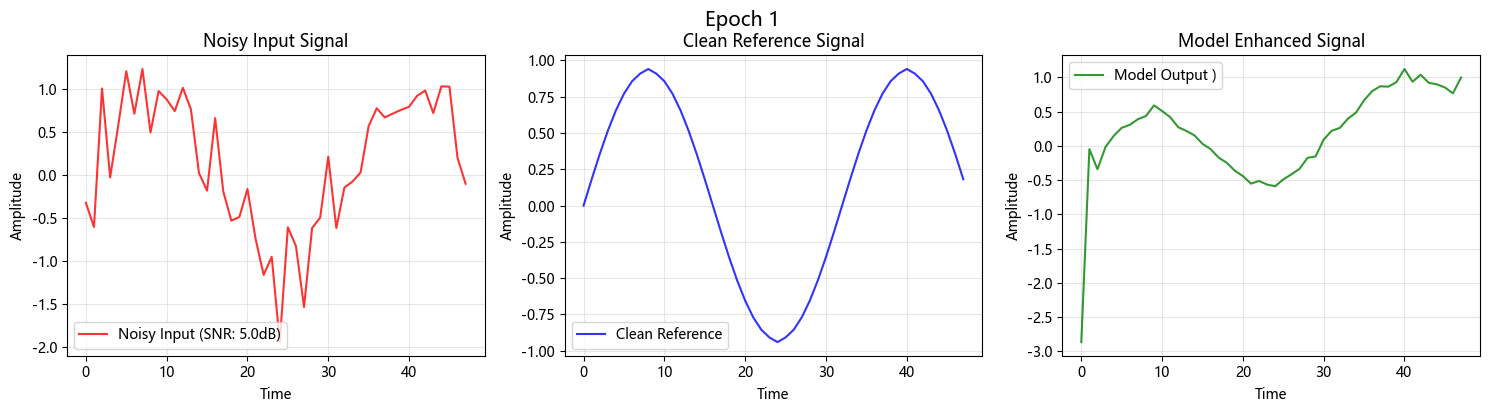

📊 训练进度: 1/100 | SNR范围: [5.0, 5.0] | 学习率: 1.00e-04
Epoch [2/100] Train Loss: 0.158438, Val Loss: 0.139431
✅ 验证损失下降，保存模型 (loss: 0.139431)
📊 训练进度: 2/100 | SNR范围: [5.0, 5.0] | 学习率: 9.99e-05
Epoch [3/100] Train Loss: 0.131732, Val Loss: 0.124576
✅ 验证损失下降，保存模型 (loss: 0.124576)
📊 训练进度: 3/100 | SNR范围: [5.0, 5.0] | 学习率: 9.98e-05
Epoch [4/100] Train Loss: 0.120179, Val Loss: 0.116229
✅ 验证损失下降，保存模型 (loss: 0.116229)


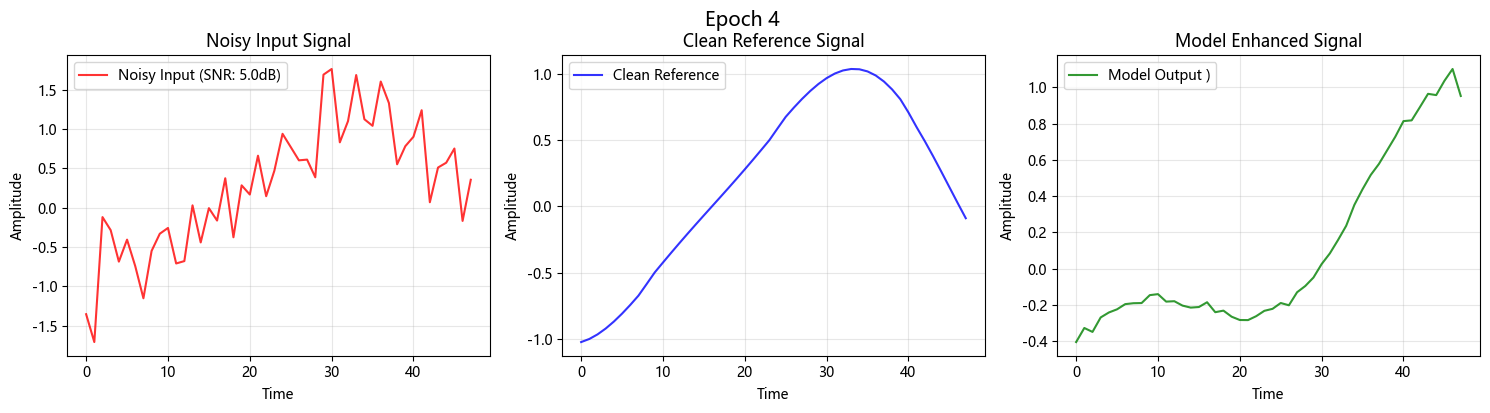

📊 训练进度: 4/100 | SNR范围: [5.0, 5.0] | 学习率: 9.96e-05
Epoch [5/100] Train Loss: 0.114799, Val Loss: 0.111806
✅ 验证损失下降，保存模型 (loss: 0.111806)
📊 训练进度: 5/100 | SNR范围: [5.0, 5.0] | 学习率: 9.94e-05
Epoch [6/100] Train Loss: 0.111141, Val Loss: 0.108923
✅ 验证损失下降，保存模型 (loss: 0.108923)
📊 训练进度: 6/100 | SNR范围: [5.0, 5.0] | 学习率: 9.91e-05
Epoch [7/100] Train Loss: 0.109486, Val Loss: 0.108222
✅ 验证损失下降，保存模型 (loss: 0.108222)


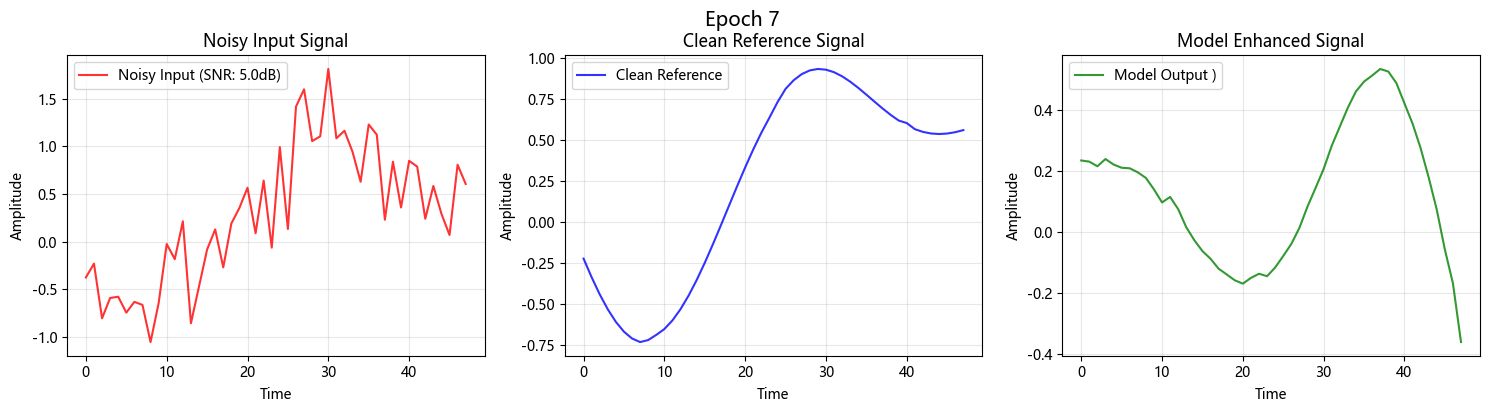

📊 训练进度: 7/100 | SNR范围: [5.0, 5.0] | 学习率: 9.88e-05
Epoch [8/100] Train Loss: 0.107914, Val Loss: 0.107332
✅ 验证损失下降，保存模型 (loss: 0.107332)
📊 训练进度: 8/100 | SNR范围: [5.0, 5.0] | 学习率: 9.84e-05
Epoch [9/100] Train Loss: 0.106481, Val Loss: 0.106603
✅ 验证损失下降，保存模型 (loss: 0.106603)
📊 训练进度: 9/100 | SNR范围: [5.0, 5.0] | 学习率: 9.80e-05
Epoch [10/100] Train Loss: 0.105624, Val Loss: 0.105419
✅ 验证损失下降，保存模型 (loss: 0.105419)


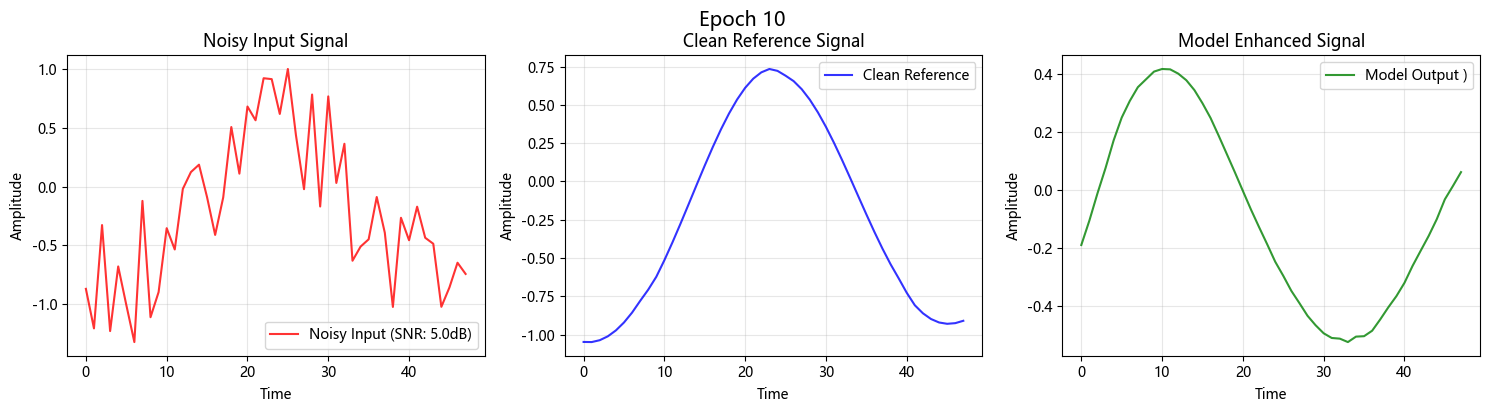

📊 训练进度: 10/100 | SNR范围: [5.0, 5.0] | 学习率: 9.76e-05
Epoch [11/100] Train Loss: 0.104942, Val Loss: 0.104471
✅ 验证损失下降，保存模型 (loss: 0.104471)
📊 训练进度: 11/100 | SNR范围: [5.0, 5.0] | 学习率: 9.71e-05
Epoch [12/100] Train Loss: 0.104054, Val Loss: 0.102742
✅ 验证损失下降，保存模型 (loss: 0.102742)
📊 训练进度: 12/100 | SNR范围: [5.0, 5.0] | 学习率: 9.65e-05
Epoch [13/100] Train Loss: 0.103385, Val Loss: 0.102309
✅ 验证损失下降，保存模型 (loss: 0.102309)


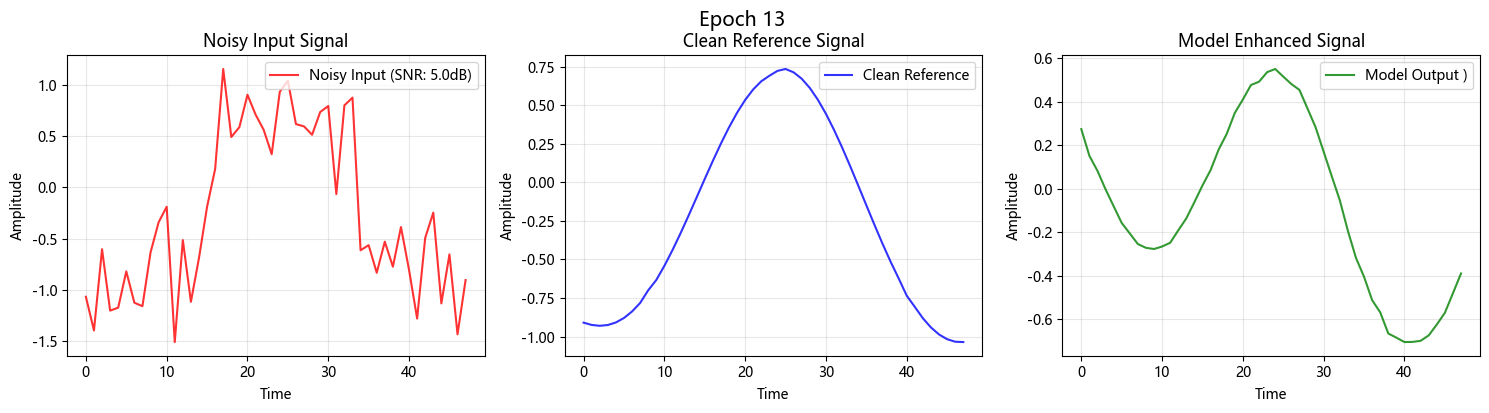

📊 训练进度: 13/100 | SNR范围: [5.0, 5.0] | 学习率: 9.59e-05
Epoch [14/100] Train Loss: 0.102197, Val Loss: 0.103169
⚠️ 验证损失没有下降 (1/10)
📊 训练进度: 14/100 | SNR范围: [5.0, 5.0] | 学习率: 9.53e-05
Epoch [15/100] Train Loss: 0.102124, Val Loss: 0.101994
✅ 验证损失下降，保存模型 (loss: 0.101994)
📊 训练进度: 15/100 | SNR范围: [5.0, 5.0] | 学习率: 9.46e-05
Epoch [16/100] Train Loss: 0.101459, Val Loss: 0.102292
⚠️ 验证损失没有下降 (1/10)


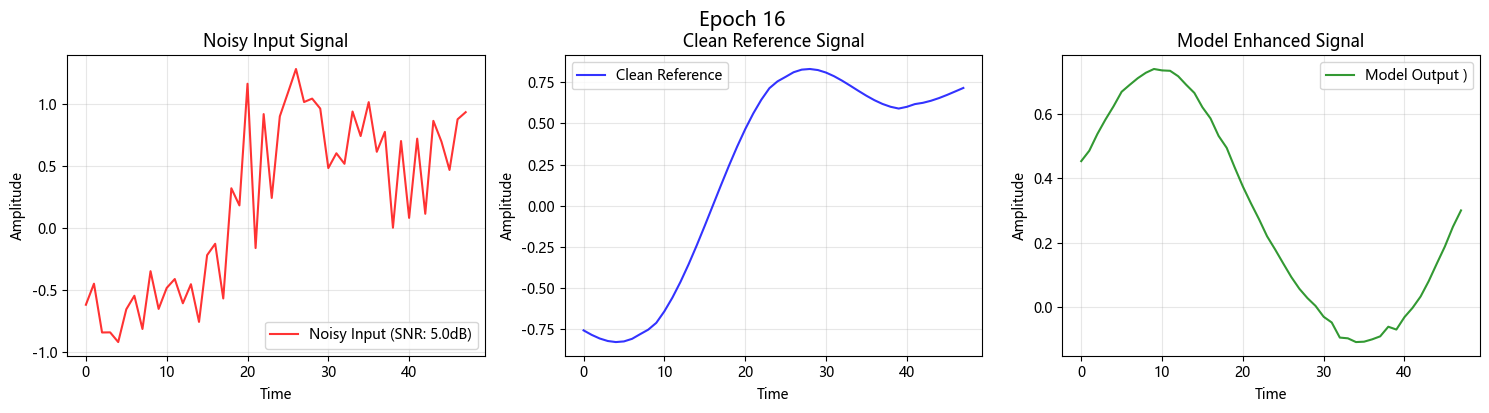

📊 训练进度: 16/100 | SNR范围: [5.0, 5.0] | 学习率: 9.39e-05


KeyboardInterrupt: 

In [84]:
# ----------训练循环（适配最优模型）----------
# ----------SNR 相关设置----------
#snr_range = np.arange(2, 16, 1)
snr_min = 5
snr_max = 5
n_steps = ddpm.n_steps

train_losses, val_losses = [], []
patience = 10
best_val_loss = float("inf")
early_stop_counter = 0

for epoch in range(epoch_num):
    # ----------训练阶段----------
    model.train()
    total_loss = 0
    
    for x, _ in train_loader:
        x = x.float().to(device)

        current_batch_size = x.shape[0]
        
        # 为当前批次添加随机 SNR 噪声
        #snr = random.uniform(snr_min, snr_max)
        snr = 5
        x_noisy = add_awgn_noise_torch(x, snr)
        
        # 时间步采样
        t = torch.randint(0, n_steps, (current_batch_size,)).to(device)
        eps = torch.randn_like(x).to(device)
        
        # 前向过程：对干净信号x添加噪声
        x_t = ddpm.sample_forward(x, t, eps)
        
        # ⚠️ 重要修正：确保输入形状匹配
        # 模型期望输入: (B, 2, 48), 条件: (B, 2, 48)
        # 但x_t和x_noisy都是(B, 2, 48)，需要检查模型输入通道数
        
        eps_theta = model(x_t, t, x_noisy)  # x_t: 带噪信号, t: 时间步, x_noisy: 条件信号
        
        loss = mse_loss(eps_theta, eps)
        
        optimizer.zero_grad()
        loss.backward()
        
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ----------验证阶段----------
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.float().to(device)
            
            current_batch_size = x.shape[0]
            
            # 验证集随机SNR
            #snr = random.uniform(snr_min, snr_max)
            snr = 5
            x_noisy = add_awgn_noise_torch(x, snr)
            
            # 时间步采样
            t = torch.randint(0, n_steps, (current_batch_size,)).to(device)
            eps = torch.randn_like(x).to(device)
            
            # 前向过程
            x_t = ddpm.sample_forward(x, t, eps)
            
            # 模型预测
            eps_theta = model(x_t, t, x_noisy)
            loss = mse_loss(eps_theta, eps)

            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epoch_num}] "
          f"Train Loss: {avg_train_loss:.6f}, "
          f"Val Loss: {avg_val_loss:.6f}")

    # ----------早停与模型保存----------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, "best_optimal_model.pth")
        print(f"✅ 验证损失下降，保存模型 (loss: {best_val_loss:.6f})")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"⚠️ 验证损失没有下降 ({early_stop_counter}/{patience})")
        if early_stop_counter >= patience:
            print("⏹️ 早停触发，停止训练。")
            break

    # ----------学习率调度----------
    if 'scheduler' in locals():
        scheduler.step()

    # ----------可视化验证集波形输出----------
    if epoch % 3 == 0:
        with torch.no_grad():
            sample_input, _ = next(iter(val_loader))
            sample_input = sample_input.float().to(device)
            
            #snr = random.uniform(snr_min, snr_max)
            snr = 5
            # 添加噪声作为条件
            sample_condition = add_awgn_noise_torch(sample_input, snr)
            
            batch_size = sample_input.size(0)
            signal_shape = (batch_size, *get_signal_shape())
            
            # 生成模型输出
            sample_output = ddpm.sample_backward(signal_shape, 
                                                model, 
                                                device=device,
                                                simple_var=True, 
                                                condition=sample_condition).detach().cpu()

            sample_input = sample_input.cpu()
            sample_condition = sample_condition.cpu()
            
            # 随机选取一个样本
            data_idx = random.randint(0, batch_size - 1)

            
            # 简洁绘图 - 只显示三个关键信号
            plt.figure(figsize=(15, 4))

            # 1. 带噪输入信号
            plt.subplot(1, 3, 1)
            plt.plot(sample_condition[data_idx, 0, :].numpy(), 
                    label=f"Noisy Input (SNR: {snr:.1f}dB)", 
                    color="red", alpha=0.8, linewidth=1.5)
            plt.title("Noisy Input Signal")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.grid(True, alpha=0.3)

            # 2. 干净参考信号
            plt.subplot(1, 3, 2)
            plt.plot(sample_input[data_idx, 0, :].numpy(), 
                    label="Clean Reference", 
                    color="blue", alpha=0.8, linewidth=1.5)
            plt.title("Clean Reference Signal")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.grid(True, alpha=0.3)

            # 3. 模型恢复信号
            plt.subplot(1, 3, 3)
            plt.plot(sample_output[data_idx, 0, :].numpy(), 
                    label=f"Model Output )", 
                    color="green", alpha=0.8, linewidth=1.5)
            plt.title("Model Enhanced Signal")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.suptitle(f"Epoch {epoch+1} ", 
                        fontsize=14, y=1.02)
            plt.show()


    current_lr = optimizer.param_groups[0]['lr']
    print(f"📊 训练进度: {epoch+1}/{epoch_num} | "
            f"SNR范围: [{snr_min:.1f}, {snr_max:.1f}] | "
            f"学习率: {current_lr:.2e}")
        

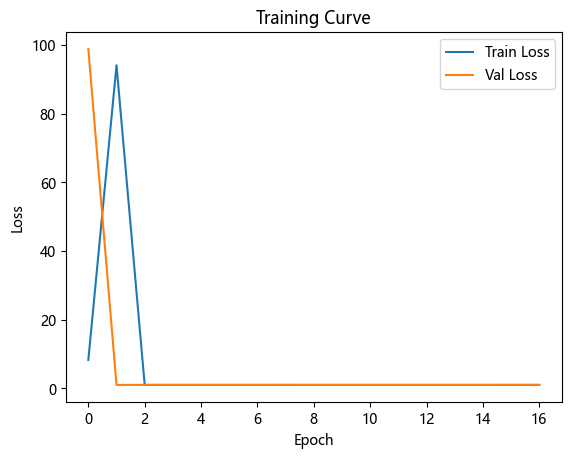

In [ ]:
#7. 可视化 Loss
# ==========================
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()

In [ ]:
#标签数据
label = np.load(r'dataset_isi_normalized\qpsk_labels.npy')  

label_data = label[100000:]

# 创建一个空的数组label_data_IQ，形状为(120000, 2)
label_data_IQ = np.zeros((len(label_data), 2), dtype=int)
# 遍历label_data，根据每个标签值更新label_data_IQ
for i in range(len(label_data)):
    if label_data[i] == 0:
        label_data_IQ[i][0] = 0
        label_data_IQ[i][1] = 0
    elif label_data[i] == 1:
        label_data_IQ[i][0] = 0
        label_data_IQ[i][1] = 1
    elif label_data[i] == 2:
        label_data_IQ[i][0] = 1
        label_data_IQ[i][1] = 1
    elif label_data[i] == 3:
        label_data_IQ[i][0] = 1
        label_data_IQ[i][1] = 0


In [ ]:
# 测试阶段

#模型去噪

def model_test(snrDB):
    test_data = Dataset(100000, 120000)
    test_data.x = add_awgn_noise_np(test_data.x, snrDB)

    test_set = test_data
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

    # 加载训练好的生成器模型
    model = VQVAE(2, 32, 256)
    model.to(device)
    model.load_state_dict(torch.load('best_Ds_model.pth', map_location=device))
    model.eval()

    # 用于存储所有生成的结果
    all_generated = []

    # 关闭梯度计算
    with torch.no_grad():
        for x, y in test_loader:
            noise_input = x.to(device).float()  
            generated, ze, zq = model(noise_input)  # 生成器输出
            all_generated.append(generated.cpu().numpy())

    # 合并所有结果 (20000, ...)
    all_generated = np.concatenate(all_generated, axis=0)

    # 重构信号
    model_signal = np.zeros((len(all_generated)*16,), dtype=np.complex64)
    baseline_signal = np.zeros((len(all_generated)*16,), dtype=np.complex64)

    for i in range(len(all_generated)):
        model_signal[16*i:16*i+16] = all_generated[i, 0, 24:40] + 1j*all_generated[i, 1, 24:40]  # 取中间16个点
        baseline_signal[16*i:16*i+16] = test_data.x[i, 0, 24:40] + 1j*test_data.x[i, 1, 24:40]  # 取中间16个点 

    return  model_signal, baseline_signal


# 下采样
def downsample(signal, SAMPLES_PER_SYMBOL=16):
    return signal[::SAMPLES_PER_SYMBOL]

# 硬判决
def decision_making(downsampled_signal, threshold=0):

    real_part = np.real(downsampled_signal)
    imag_part = np.imag(downsampled_signal)

    decision = np.zeros((len(downsampled_signal),2), dtype=int)
    #print(real_part[:10])
    #print(imag_part[:10])
    for i in range(len(downsampled_signal)):
        if (real_part[i] > threshold) and (imag_part[i] > threshold):
            decision[i,0] = 0 
            decision[i,1] = 0
        elif (real_part[i] < threshold) and (imag_part[i] > threshold):
            decision[i,0] = 0 
            decision[i,1] = 1
        elif (real_part[i] < threshold) and (imag_part[i] < threshold):
            decision[i,0] = 1 
            decision[i,1] = 1
        elif (real_part[i] > threshold) and (imag_part[i] < threshold):
            decision[i,0] = 1
            decision[i,1] = 0
    #print(decision[:10])
    return decision

# 计算误码率
def calculate_ber(original_labels, predicted_labels):
    
    predicted_labels = predicted_labels.astype(int)

    
    #print(original_labels[:10])
    #print(predicted_labels[:10])
    error_num_i = 0
    error_num_q = 0
    error_num = 0
    
    error_num_i = np.sum(original_labels[:, 0] != predicted_labels[:, 0])
    error_num_q = np.sum(original_labels[:, 1] != predicted_labels[:, 1])

    error_num = error_num_i + error_num_q

    #print(error_num_i)
    #print(error_num_q)
    ber = error_num / (len(original_labels)*2)
    print(ber)
    return ber

# 接收器
def matched_filter_decision(labels, snr_db, SAMPLES_PER_SYMBOL=16):

    recovered_signal, baseline_signal = model_test(snr_db) 
    # 下采样
    #print(recovered_signal[:10])
    downsampled_model_signal = downsample(recovered_signal, SAMPLES_PER_SYMBOL)
    downsampled_baseline_signal = downsample(baseline_signal, SAMPLES_PER_SYMBOL)
    # 硬判决
    predicted_model_labels = decision_making(downsampled_model_signal)
    predicted_baseline_labels = decision_making(downsampled_baseline_signal)

    # 确保 labels 和 predicted_labels 都是扁平化的一维数组
    model_ber = calculate_ber(labels, predicted_model_labels)
    baseline_ber = calculate_ber(labels, predicted_baseline_labels)
    return model_ber, baseline_ber


In [ ]:
# 绘制BER曲线
def plot_ber_curve(output_re_bers, baseline_bers, snr_range):
    plt.figure(figsize=(12, 8))
    
    # 绘制模型BER曲线
    plt.semilogy(snr_range, output_re_bers, 'o-', label='Model')

    theoretical_bers = []
    for snr_db in snr_range:
        snr_db = snr_db + 10*math.log10(16)
        snr_linear = 10 ** (snr_db / 10)
        theoretical_bers.append(0.5 * erfc(np.sqrt(snr_linear/2)))

    # 绘制理论BER曲线
    plt.semilogy(snr_range, theoretical_bers, 'r--', label='匹配滤波器')
    theoretical_num = []
    for i in range(len(theoretical_bers)):
        theoretical_num.append(theoretical_bers[i])
    print(theoretical_num)
    # 关键：设置横轴仅显示偶数刻度
    min_snr = np.min(snr_range)
    max_snr = np.max(snr_range)

    # 绘制baseline
    plt.semilogy(snr_range, baseline_bers, 'v-', label='baseline')
    
    # 生成从 min_snr 到 max_snr 的偶数序列，np.arange 步长设为 2
    xticks = np.arange(np.ceil(min_snr / 2) * 2, np.floor(max_snr / 2) * 2 + 2, 2)
    plt.xticks(xticks)  

    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.title('Bit Error Rate vs. SNR (QPSK)')
    plt.legend()
    plt.show()



    

In [ ]:

model_bers = []
baseline_bers = []
for snr_db in snr_range:
    print(f"当前SNR: {snr_db} dB")
    model_ber, baseline_ber =  matched_filter_decision(label_data_IQ, snr_db)
        
    model_bers.append(model_ber)
    baseline_bers.append(baseline_ber)

#绘图
plot_ber_curve(model_bers, baseline_bers, snr_range)


        

当前SNR: 2 dB


NameError: name 'VQVAE' is not defined